In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

import torch
from torch import nn

from utils import get_gaussian_targets
from models import RNN
from train import test_and_get_stats, train_bptt, train_bptt_sparse
from viz import (plot_learning, plot_state_traj, plot_all_units,
                 plot_weight_distr)

In [2]:
# set meta-parameters
# for plotting style
custom_params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(style='ticks', rc=custom_params)
# for pytorch tensors
device = 'cpu'
# for reproducibility while troubleshooting; numpy is for model sparse conns
torch.random.manual_seed(93214)
np.random.seed(35107)

Test loss: 2.762423
Iteration 1


/home/ryan/time_coding/train.py:240: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteration 78
Iterati

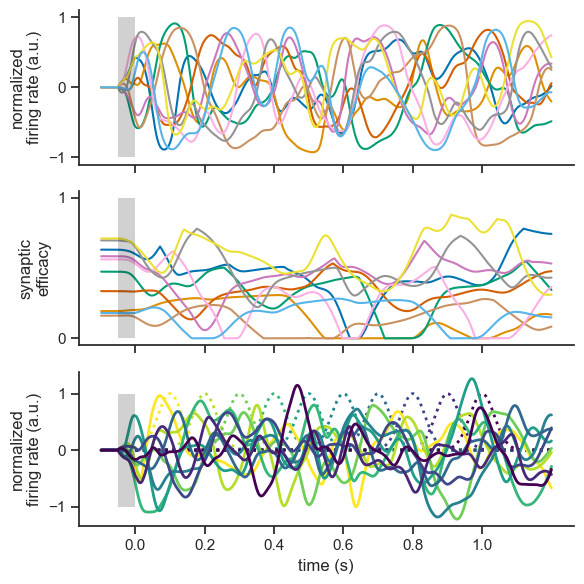

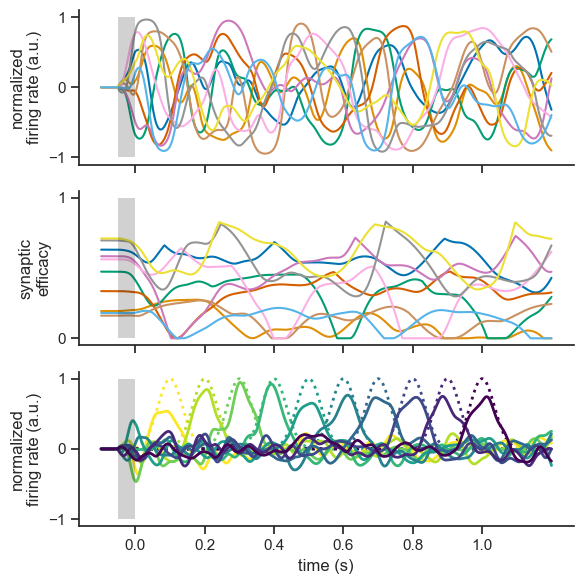

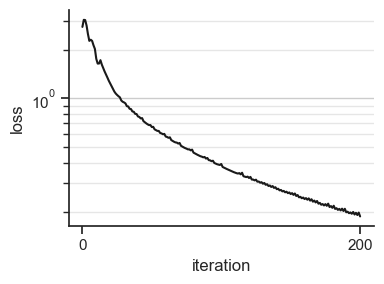

In [3]:
# instantiate model, loss function, and optimizer
include_stp = True
n_inputs, n_hidden, n_outputs = 1, 500, 10
model = RNN(n_inputs=n_inputs, n_hidden=n_hidden,
            n_outputs=n_outputs, include_stp=include_stp)
model.to(device)

mse_fn = nn.MSELoss()
loss_fn = lambda a, b: mse_fn(a, b) / b.mean()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# set parameters
# simulation parameters
dt = 1e-3  # 1 ms
tstop = 1.2  # 1 sec
times = np.arange(-0.1 + dt, tstop + dt, dt)
n_times = len(times)

# define inputs (for contextual modulation / recurrent perturbations)
n_batches = 1
inputs = torch.zeros((n_batches, n_times, n_inputs))
perturb_dur = 0.05  # 50 ms
perturb_win_mask = np.logical_and(times > -perturb_dur, times < 0)
inputs[:, perturb_win_mask, :] = 1.0

# define output targets
# set std s.t. amplitude decays to 1/e at intersection with next target
targ_std = 0.05 / np.sqrt(2)  # ~35 ms
# tile center of target delays spanning sim duration (minus margins)
delay_times = np.linspace(0.1, 1.0, n_outputs)
targets = get_gaussian_targets(n_batches, delay_times, times, targ_std)

# set initial conditions of recurrent units fixed across iterations of
# training and testing
# h_0 = torch.rand(n_hidden) * 2 - 1  # uniform in (-1, 1)
h_0 = torch.zeros(n_hidden)
h_0 = torch.tile(h_0, (n_batches, 1))  # replicate for each batch
# r_0 = torch.rand(n_hidden)
# r_0 = torch.rand(n_hidden) * model.p_rel.detach()  # uniform in (0, p_rel)
# r_0 = model.p_rel.detach() / (1 + model.beta * 0.5 * model.tau_depr)  # uniform in (0, p_rel)
# r_0 = model.p_rel.detach()
r_0 = torch.ones(n_hidden)
r_0 = torch.tile(r_0, (n_batches, 1))
# u_0 = torch.rand(n_hidden) # uniform in (0, 1)
u_0 = model.p_rel.detach()
u_0 = torch.tile(u_0, (n_batches, 1))

# run opt routine
# move to desired device
inputs = inputs.to(device)
targets = targets.to(device)
h_0 = h_0.to(device)
r_0 = r_0.to(device)
u_0 = u_0.to(device)

# plot model output before training
_, sim_stats_0 = test_and_get_stats(inputs, targets, times,
                                    model, loss_fn,
                                    h_0, r_0, u_0, plot=True)

p_rel = model.p_rel
if include_stp is False:
    p_rel = 1.0
weights_0 = model.gain * model.W_hh * model.presyn_scaling.detach() * p_rel

# pre-train
# max_iter_pretrain = 10
# for iter_idx in range(max_iter_pretrain):
#     _ = pre_train(inputs, times, model, h_0)

# train model weights
max_iter = 400
convergence_reached = False
loss_per_iter = list()
for iter_idx in range(max_iter):
    print(f"Iteration {iter_idx + 1}")
    # loss, param_dist = train_force(inputs, targets, times, model, loss_fn,
    #                                optimizer, h_0, r_0, u_0,
    #                                presyn_idx=iter_idx)
    # loss = train_bptt_sparse(inputs, targets, times, model, loss_fn, optimizer,
    #                          h_0, r_0, u_0, p_backprop=0.2)
    loss = train_bptt(inputs, targets, times, model, loss_fn, optimizer,
                      h_0, r_0, u_0)
    loss_per_iter.append(loss)
    if len(loss_per_iter) >= 10:
        mean_diff = np.diff(loss_per_iter[-10:]).mean()
        if np.abs(mean_diff) < 1e-4:
            convergence_reached = True
            break

weights_1 = model.gain * model.W_hh * model.presyn_scaling.detach() * p_rel

# print(f"Trial {sample_idx} training complete!!")
if not convergence_reached:
    print(f"Warning: didn't converge!!!")

# investigate fitted model
# plot model output after training
state_vars_1, sim_stats_1 = test_and_get_stats(inputs, targets, times,
                                               model, loss_fn, h_0, r_0,
                                               u_0, plot=True)
hidden_sr_1, r_1, u_1, output_sr_1 = state_vars_1
loss_per_iter.append(sim_stats_1['loss'])
# loss when the output flatlines
loss_baseline = targets[:, times > 0, :].mean()
# losses = np.array(loss_per_iter) / loss_baseline.item()
losses = np.array(loss_per_iter)

# plot loss across training
fig_learning = plot_learning(losses, max_iter=None)
# plt.savefig('/home/ryan/Desktop/training_loss_force.png')

[]

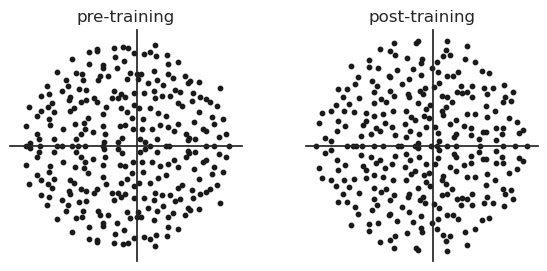

In [4]:
# weights = model.W_hh * model.presyn_scaling.detach() * model.p_rel
angles = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7, 3))

jacobian_0 = (weights_0 - torch.eye(model.n_hidden)) * 0.001 / model.tau
eigvals_0, eigvecs_0 = scipy.linalg.eig(jacobian_0)
# ax[0].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[0].scatter(eigvals_0.real, eigvals_0.imag, c='k', s=10)
ax[0].set_title('pre-training')

jacobian_1 = (weights_1 - torch.eye(model.n_hidden)) * 0.001 / model.tau
eigvals_1, eigvecs_1 = scipy.linalg.eig(jacobian_1)
# ax[1].plot(np.cos(angles)-1, np.sin(angles), 'r')
ax[1].scatter(eigvals_1.real, eigvals_1.imag, c='k', s=10)
ax[1].set_title('post-training')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

ax[0].spines['left'].set_position('zero')
ax[0].spines['bottom'].set_position('zero')
ax[1].spines['left'].set_position('zero')
ax[1].spines['bottom'].set_position('zero')
ax[1].set_yticks([])
ax[1].set_xticks([])

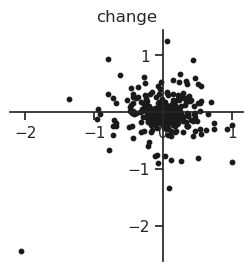

In [33]:
jac_diff = jacobian_1 - jacobian_0
eigval_perturb = np.diag((eigvecs_0 - eigvals_0 * np.eye(model.n_hidden)) @ jac_diff.numpy() @ np.linalg.inv(jacobian_0))
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(3, 3))
ax.scatter(eigval_perturb.real, eigval_perturb.imag, c='k', s=10)
ax.set_title('change')

# ax.set_aspect('equal')

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
# ax.set_yticks([])
# ax.set_xticks([])

In [34]:
eigval_perturb.shape

(300,)

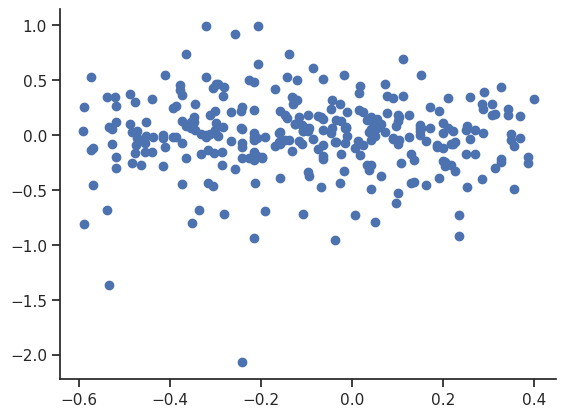

In [35]:
pos_eigvals = eigvals_0.real[eigvals_0.real > 0]
sort_idx = np.argsort(eigvals_0.real)
plt.figure()
plt.scatter(eigvals_0.real, eigval_perturb.real)

In [27]:
eigval_perturb.shape

(300, 300)

In [4]:
sim_stats_0['dimensionality']

3.3300537560216683

In [5]:
sim_stats_1['dimensionality']

3.714206065600773

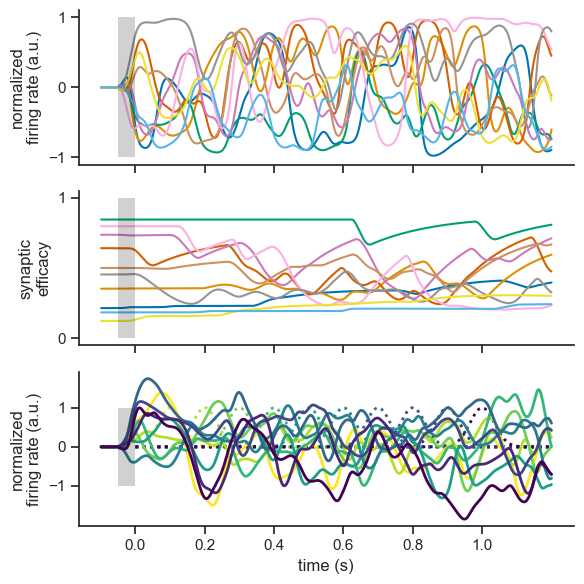

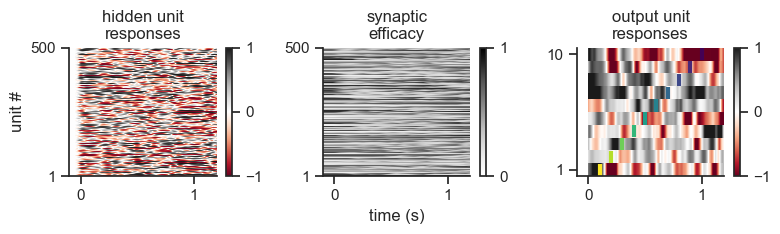

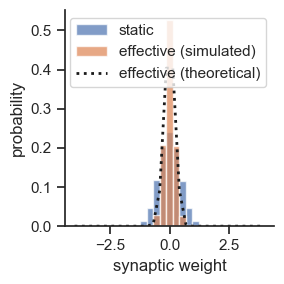

In [9]:
dt = times[1] - times[0]
model.eval()

with torch.no_grad():

    # Compute prediction error
    h_t, r_t, u_t, z_t, dhdh_t = model(inputs, h_0=h_0, r_0=r_0, u_0=u_0, dt=dt, return_dhdh=True)
    loss = loss_fn(z_t[:, times > 0, :], targets[:, times > 0, :])

weights = model.W_hh * model.presyn_scaling.detach()
prob_c = float(torch.count_nonzero(model.W_hh_mask) /
               torch.numel(model.W_hh_mask))

# select first batch if more than one exists
hidden_batch = torch.tanh(h_t).cpu()[0]
syn_eff_batch = r_t.cpu()[0] * u_t.cpu()[0]
outputs_batch = z_t.cpu()[0]
targets_batch = targets.cpu()[0]

fig_traj = plot_state_traj(h_units=hidden_batch, outputs=outputs_batch,
                           syn_eff=syn_eff_batch,
                           targets=targets_batch, times=times)

fig_all_units = plot_all_units(h_units=hidden_batch, syn_eff=syn_eff_batch,
                               outputs=outputs_batch,
                               targets=targets_batch, times=times)

fig_weights_distr = plot_weight_distr(weights, model.W_hh_mask,
                                      syn_eff_batch,
                                      eff_gain=model.effective_gain,
                                      true_gain=model.gain,
                                      prob_c=prob_c)
plt.show()

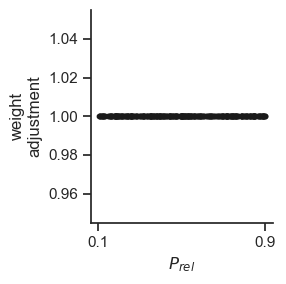

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(3, 3))
# sort_idxs = np.argsort(model.p_rel.detach().numpy())
p_rel = model.p_rel.detach().numpy()
post_syn_adjustment = model.presyn_scaling.detach().numpy()
axes.scatter(p_rel, post_syn_adjustment, s=10, c='k')
axes.set_xticks([0.1, 0.9])
axes.set_xlabel('$P_{rel}$')

# axes.set_yticks([0, np.max(post_syn_adjustment).round(decimals=1)])
axes.set_ylabel('weight\nadjustment')
fig.tight_layout()

In [ ]:
dhdh_t_batch = dhdh_t[0].cpu()
dh

(array([  49,   50,   51, ..., 1197, 1198, 1199]),)

In [8]:
dhdh_t[0, -1, :]

tensor([  0.9232,   1.0039,   1.2146,   1.3067,   0.9179,   1.0058,   1.0219,
          1.0163,   1.0436,   1.0001,   0.9882,   1.1612,   0.9773,   0.9267,
          0.8346,   1.1503,   0.9197,   0.9877,   0.9204,   0.9194,   0.9452,
          1.0295,   0.9818,   0.8892,   1.0304,   0.7978,   0.9148,   1.0383,
          1.0854,   1.0169,   0.7829,   1.0479,   0.9629,   0.9584,   0.9868,
          1.1023,   1.0036,   0.9416,   0.9267,   1.0120,   1.0309,   0.9113,
          0.8620,   0.9551,   1.1825,   0.9548,   0.8753,   1.0712,   0.8548,
          0.9585,   2.1194,   0.9243,   1.0159,  10.2229,   0.9236,   0.8809,
          0.8873,   1.0230,   1.3648,   0.9888,   0.9411,   1.0019,   1.2520,
          1.1657,   1.0497,   0.9282,   0.8071,   1.1096,   1.0269,   1.7131,
          1.0088,   0.5928,   0.2820,   0.9902,   0.8446,   1.0481,   0.9247,
          1.0056,   0.8987,   1.1063,   0.8528,   0.8027,   0.9392,   0.9946,
          0.7353,   0.9762,   1.0957,   0.9989,   1.4460,   1.16

In [ ]:
fig_traj.savefig('/home/ryan/Desktop/traj_gain_scaled_hz_nonforce_postlearning.png')
fig_all_units.savefig('/home/ryan/Desktop/units_all_gain_scaled_hz_nonforce_postlearning.png')
fig_weights_distr.savefig('/home/ryan/Desktop/hidden_weights_gain_scaling_postlearning.png')